In [5]:
using LinearAlgebra
using Distributions
using Interpolations
using Optim
using Plots
using StatsBase
using LaTeXStrings
using QuantEcon
using IJulia
using Inequality

plot_font = "Computer Modern"
default(fontfamily=plot_font,
        linewidth=2, framestyle=:box, label=nothing, grid=false)
scalefontsizes(1)

### Wealth distribution routines

In [6]:
function find_closest_numbers(arr, target)
    # Calculate the absolute differences between each element and the target
    differences = abs.(arr .- target)
    
    # Find the indices that would sort the differences
    sorted_indices = sortperm(differences)
    
    # Take the two closest values based on the sorted indices
    closest_values = arr[sorted_indices[1:2]]
    
    return closest_values
end

function stationary_dist(A, E, Π, AP)
    next::Array{Float64, 4} = ones(length(A), length(E), length(A), length(E))

    Threads.@threads for idx1 in eachindex(A) # a
                    for idx5 in eachindex(E) # ε
                         for idx6 in eachindex(A) # a'
                                        for idx10 in eachindex(E) # ε'
                                            closest = find_closest_numbers(A, AP[idx1, idx5])
                                            @inbounds next[idx1, idx5, idx6, idx10] = (A[idx6] == closest[1])*Π[idx5, idx10]
                                        end
                                    end
                                end
                            end

    #println("Transition Matrix computed")

    # Once we computed our matrix

    Pmat = reshape(next, (length(A)*length(E), length(A)*length(E)))
    stationary_distribution = QuantEcon.stationary_distributions(QuantEcon.MarkovChain(reverse(Pmat)))
    n_distr = length(stationary_distribution)
    #println("There are $n_distr stationary distributions, picking the first")
    
    return reshape(stationary_distribution[1], (length(A), length(E))), stationary_distributions
end

function wealth_distribution(λ, A, E)
    return reshape(sum(λ, dims=(2)),length(A))
end

wealth_distribution (generic function with 1 method)

### Other functions

In [7]:
function ufun(c, σ)
    if σ != 1
        return (c.^(1 - σ) - 1)./(1 - σ);
    else 
        return log.(c)
    end
end

function intEV(EV, Ap, Ep, CurrE, Π)
    logsum = EV(Ap, Ep)'*Π[CurrE, :]
    return logsum
end

intEV (generic function with 1 method)

## Bellman operator

In [8]:
function T(agrid, egrid, o, r, β, σ_ϕ, σ, w1, w2, u, A, E, O, Π, EV, Γ)

    v::Array{Float64, 3} = zeros(agrid, egrid, o)
    c::Array{Float64, 3} = zeros(agrid, egrid, o)

    # For each point in the domain
    Threads.@threads for idx1 in eachindex(A) # ∀ a ∈ A
                    for idx5 in eachindex(E)  # ∀ ε ∈ E
                        
                        # Choice 1
                        v1 = c -> -(ufun(c, σ) + β*intEV(EV, ((1+r)*A[idx1] + Γ[1]*exp(E[idx5])*w1 - c), E, idx5, Π))
            
                        # Choice 2
                        v2 = c -> -(ufun(c, σ) + β*intEV(EV, ((1+r)*A[idx1] + Γ[2]*exp(E[idx5])*w2 - c), E, idx5, Π))

                        # Choice 3
                        v3 = c -> -(ufun(c, σ) +  β*intEV(EV, ((1+r)*A[idx1] + u - c), E, idx5, Π))
                        
                        # Find solution to optimization
                        res1 = optimize(v1, 0, (1+r)*A[idx1] + Γ[1]*exp(E[idx5])*w1)
                        res2 = optimize(v2, 0, (1+r)*A[idx1] + Γ[2]*exp(E[idx5])*w2)
                        res3 = optimize(v3, 0, (1+r)*A[idx1] + u)

                        # Instantiate the points
                        @inbounds v[idx1, idx5, 1] = -Optim.minimum(res1)
                        @inbounds v[idx1, idx5, 2] = -Optim.minimum(res2)
                        @inbounds v[idx1, idx5, 3] = -Optim.minimum(res3)

                        @inbounds c[idx1, idx5, 1] = Optim.minimizer(res1)[1]
                        @inbounds c[idx1, idx5, 2] = Optim.minimizer(res2)[1]
                        @inbounds c[idx1, idx5, 3] = Optim.minimizer(res3)[1]
                    end
    end

    # Numerical stability constant
    M = maximum(v)

    # Compute the logsum 
    EV1 = M .+ σ_ϕ.*log.(exp.((v[:,:,1] .- M)./σ_ϕ) .+ exp.((v[:,:,2] .- M)./σ_ϕ) .+ exp.((v[:,:,3] .- M)./σ_ϕ))

    # Interpolation step
    EV1 = linear_interpolation((A, E), EV1, extrapolation_bc=Line());

    return EV1, v, c
end

T (generic function with 1 method)

## Solver

In [9]:
# Solve the Model
function solver(σ, σ_ϕ, r, w1, w2, u, β, Γ, agrid)

    ########################## Model settings
    
    ########################################### STATE SPACE VARIABLES
    # Discretize the state space
    egrid::Int64 = 30
    o::Int64 = 3

    ρ::Float64 = 0.7
    nstd = 2
        
    A = LinRange(0.01, 5, agrid) # Asset space
    E = QuantEcon.tauchen(egrid, ρ, 0.5, 0, nstd).state_values # Shock space
    O::LinRange{Int64, Int64} = LinRange(1, o, o) # Occupational set

    # Transition matrix
    Π = QuantEcon.tauchen(egrid, ρ, 1., 0, nstd).p

    #################################################### Initial Guess on EV
    EV = linear_interpolation((A, E), zeros(agrid, egrid), extrapolation_bc=Line());

    v::Array{Float64, 3} = zeros(agrid, egrid, o)
    c::Array{Float64, 3} = zeros(agrid, egrid, o)

    # Tolerance and 
    ε = 1e-04;
    err = Inf;

    println("Starting Value Function Iteration")
    # Solution loop
    while err > ε
        # Apply the operator and get the new value function
        EV1, v, c = T(agrid, egrid, o, r, β, σ_ϕ, σ, w1, w2, u, A, E, O, Π, EV, Γ)
    
        # Compute the error 
        err = StatsBase.Linfdist(EV1(A, E), EV(A, E))
        #println(err)
    
        # Update EV
        EV = EV1
    end
    #println("Value Function Iteration converged")

    #println("Computing CCP")
    # Compute choice probabilities
    M = maximum(v)
    p1 = exp.((v[:,:,1] .- M)./σ_ϕ)./(exp.((v[:,:,1] .- M)./σ_ϕ) + exp.( (v[:,:,2] .- M)./σ_ϕ) + exp.((v[:,:,3] .- M)./σ_ϕ))
    p2 = exp.((v[:,:,2] .- M)./σ_ϕ)./(exp.((v[:,:,1] .- M)./σ_ϕ) .+ exp.((v[:,:,2] .- M)./σ_ϕ) .+ exp.((v[:,:,3] .- M)/σ_ϕ))
    pu = 1 .- p1 .- p2

    #println("Computing AP")

    # Reconstruct ap
    ap::Array{Float64, 3} = zeros(agrid, egrid, o)
    for (idx1, a) in enumerate(A)
        for (idx5, e) in enumerate(E)
            ap[idx1, idx5, 1] = (1 + 0.03)*a + Γ[1]*exp(E[idx5])*w1 - c[idx1, idx5, 1]
            ap[idx1, idx5, 2] = (1 + 0.03)*a + Γ[2]*exp(E[idx5])*w2 - c[idx1, idx5, 2]
            ap[idx1, idx5, 3] = (1 + 0.03)*a + u - c[idx1, idx5, 3]
        end
    end

    C = c[:,:,1].*p1 + c[:,:,2].*p2 + c[:,:,3].*pu;
    AP = ap[:,:,1].*p1 + ap[:,:,2].*p2 + ap[:,:,3].*pu;

    #println("Computing Stationary Distribution")
    λ, distributions = stationary_dist(A, E, Π, AP)
    #println("Stationary Distribution Found")

    #println("Computing Wealth Distribution")
    WD = wealth_distribution(λ, A, E);

    #println("Finished")
    return EV, p1, p2, pu, v, A, E, C, AP, λ, WD
end

solver (generic function with 1 method)

# Model Solution

In [10]:
#= Γ_1 = [1 0.8]
Γ_2 = [0.8 1]
β = 0.96
w1 = 2
w2 = 2
u = 0.5
σ = 2
σ_ϕ = 1

EV_1, p1_1, p2_1, pu_1, v_1, A, E, C_1, AP_1, λ_1, WD_1 = solver(σ, σ_ϕ, w1, w2, u, β, Γ_1);
EV_2, p1_2, p2_2, pu_2, v_2, A, E, C_2, AP_2, λ_2, WD_2 = solver(σ, σ_ϕ, w1, w2, u, β, Γ_1); =#

# Aggregate Measures

In [13]:
function eq_prices(α, ξ, r, u, m1, m2, agrid, L1_init, L2_init, bisection_weights)

    # Parameters
    Γ_1 = [1 0.32]
    Γ_2 = [0.45 1]
    β = 0.96
    σ = 2
    σ_ϕ = 1

    ε = 1e-02
    it = 0
    it_max = 10

    # Inital guess of capital and labor
    L1 = L1_init
    L2 = L2_init

    while it < it_max
        w1 = α*L1^(α-1)
        w2 = ξ*L1^(ξ-1)
        println("Current prices, r=$r, w1=$w1, w2=$w2")

        # Compute the model at that eq_prices
        EV_1, p1_1, p2_1, pu_1, v_1, A, E, C_1, AP_1, λ_1, WD_1 = solver(σ, σ_ϕ, r, w1, w2, u, β, Γ_1, agrid) # Solve the Model for type 1
        EV_2, p1_2, p2_2, pu_2, v_2, A, E, C_2, AP_2, λ_2, WD_2 = solver(σ, σ_ϕ, r, w1, w2, u, β, Γ_2, agrid) # Solve the model for type 2

        # Compute aggregate capital and labor supply
        L1_new = effective_labor_supply(p1_1, p1_2, m1, m2, λ_1, λ_2, A, E, [Γ_1[1], Γ_2[1]])
        L2_new = effective_labor_supply(p2_1, p2_2, m1, m2, λ_1, λ_2, A, E, [Γ_1[2], Γ_2[2]])

        println(abs(L1_new - L1))
        println(abs(L2_new - L2))

        if (abs(L1_new - L1) < ε) & (abs(L2_new - L2) < ε)
            println("Approximate equilibrium found at r=$r, w1 = $w1, w2 = $w2")
            break
        else
            L1 = bisection_weights*L1_new + (1 - bisection_weights)*L1
            L2 = bisection_weights*L2_new + (1 - bisection_weights)*L2 
            it = it + 1
        end
    end

    return w1, w2
end

eq_prices (generic function with 1 method)

In [11]:
function employment_rate(p1, p2, m1, m2, λ1, λ2, A, E)
    E11 = p1.*λ1
    E12 = p2.*λ2
    return sum(m1*E11 + m2*E12)
end

function effective_labor_supply(p1, p2, m1, m2, λ1, λ2, A, E, Γ)
    E11 = p1.*λ1
    E12 = p2.*λ2
    return sum(m1*E11*Γ[1] + m2*E12*Γ[2])
end

function agg_consumption(c1, c2, m1, m2, λ1, λ2)
    C1 = c1.*λ1
    C2 = c2.*λ2
    return sum(m1*C1 + m2*C2)
end

function agg_savings(s1, s2, m1, m2, λ1, λ2)
    S1 = s1.*λ1
    S2 = s2.*λ2
    return sum(m1*S1 + m2*S2)
end

agg_savings (generic function with 1 method)

# Sectoral Shocks

In [12]:
function simulate_sectoral_shock(r, w1, u, w2lb, w2ub, n_grid, m1, m2, agrid)

    W2 = LinRange(w2lb, w2ub, n_grid)
    WDIST = zeros(n_grid, agrid)
    summary_mat = zeros(12, n_grid)

    # Parameters
    Γ_1 = [1 0.32]
    Γ_2 = [0.45 1]
    β = 0.96
    σ = 2
    σ_ϕ = 1

    Threads.@threads for i in eachindex(W2) # For every wage 2, in parallel

        EV_1, p1_1, p2_1, pu_1, v_1, A, E, C_1, AP_1, λ_1, WD_1 = solver(σ, σ_ϕ, r, w1, W2[i], u, β, Γ_1, agrid); # Solve the Model for type 1
        EV_2, p1_2, p2_2, pu_2, v_2, A, E, C_2, AP_2, λ_2, WD_2 = solver(σ, σ_ϕ, r, w1, W2[i], u, β, Γ_2, agrid); # Solve the model for type 2

        # Compute aggregate measures
        E1 = employment_rate(p1_1, p1_2, m1, m2, λ_1, λ_2, A, E)
        E2 = employment_rate(p2_1, p2_2, m1, m2, λ_1, λ_2, A, E)
        E = E1 + E2
        U =  employment_rate(pu_1, pu_2, m1, m2, λ_1, λ_2, A, E)

        L1 = effective_labor_supply(p1_1, p1_2, m1, m2, λ_1, λ_2, A, E, [Γ_1[1], Γ_2[1]])
        L2 = effective_labor_supply(p2_1, p2_2, m1, m2, λ_1, λ_2, A, E, [Γ_1[2], Γ_2[2]])
        L = L1 + L2
        
        mean_prod_1 = L1/E1
        mean_prod_2 = L2/E2
        prod = L/E

        C = agg_consumption(C_1, C_2, m1, m2, λ_1, λ_2) 
        S = agg_savings(AP_1, AP_2, m1, m2, λ_1, λ_2)



        summary_mat[1, i] = E1
        summary_mat[2, i] = E2
        summary_mat[3, i] = E
        summary_mat[4, i] = U

        summary_mat[5, i] = L1
        summary_mat[6, i] = L2
        summary_mat[7, i] = L

        summary_mat[8, i] = mean_prod_1
        summary_mat[9, i] = mean_prod_2
        summary_mat[10, i] = prod

        summary_mat[11, i] = C
        summary_mat[12, i] = S

        WDIST[i,:] = m1*WD_1 + m2*WD_2
    end

    return summary_mat, W2, WDIST
end

simulate_sectoral_shock (generic function with 1 method)

In [32]:
sector_shock, W2, WDIST = simulate_sectoral_shock(0.03, 1, 0.5, 1, 1.5, 5, 0.6, 0.4, 50)

Starting Value Function Iteration
Starting Value Function Iteration
Starting Value Function Iteration
Starting Value Function Iteration
Starting Value Function Iteration
Starting Value Function Iteration
Starting Value Function Iteration
Starting Value Function Iteration
Starting Value Function Iteration
Starting Value Function Iteration


([0.42446295219551444 0.4114572811681514 … 0.3882384139838555 0.377526972366445; 0.302158167503381 0.3241019442373788 … 0.36337339447665146 0.38116337426876534; … ; 0.7704974266626845 0.7827271825375386 … 0.8094799581647504 0.8233761826455337; 1.9675216265358695 1.9385254647725105 … 1.9245125481780483 1.930153430208952], LinRange{Float64}(1.0, 1.5, 5), [0.2359014657127837 0.03089117993775709 … 0.015080414477421155 0.0; 0.25474705652840096 0.02763972072983967 … 0.013253102652519163 0.0; … ; 0.28190104976223634 0.027823460429858282 … 0.012686206894556702 0.000700899102625667; 0.28986510239928664 0.02877389723432356 … 0.012840468775624185 0.0007496329403306898])

In [33]:
sector_shock

12×5 Matrix{Float64}:
 0.424463  0.411457  0.399854  0.388238  0.377527
 0.302158  0.324102  0.343933  0.363373  0.381163
 0.726621  0.735559  0.743787  0.751612  0.75869
 0.273379  0.264441  0.256213  0.248388  0.24131
 0.386012  0.37692   0.368241  0.359355  0.35072
 0.248115  0.265115  0.279666  0.293497  0.305423
 0.634127  0.642034  0.647907  0.652852  0.656143
 0.909412  0.916061  0.920938  0.925604  0.928994
 0.821143  0.817998  0.81314   0.807701  0.801291
 0.872706  0.872852  0.871091  0.868602  0.864836
 0.770497  0.782727  0.796479  0.80948   0.823376
 1.96752   1.93853   1.93206   1.92451   1.93015

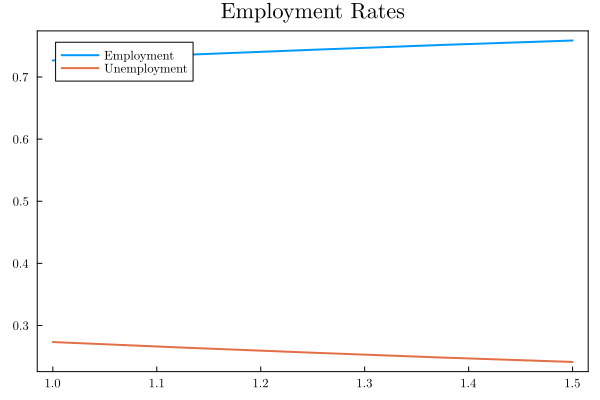

In [34]:
plot(W2, sector_shock[3,:], label="Employment", title="Employment Rates")
plot!(W2, sector_shock[4,:], label="Unemployment")

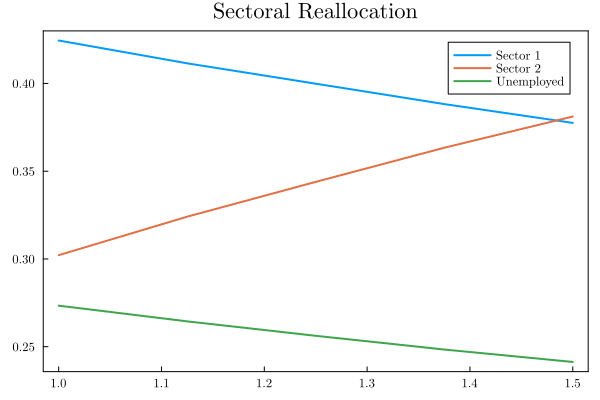

In [35]:
plot(W2, sector_shock[1,:], label="Sector 1", title="Sectoral Reallocation")
plot!(W2, sector_shock[2,:], label="Sector 2")
plot!(W2, sector_shock[4,:],label="Unemployed")

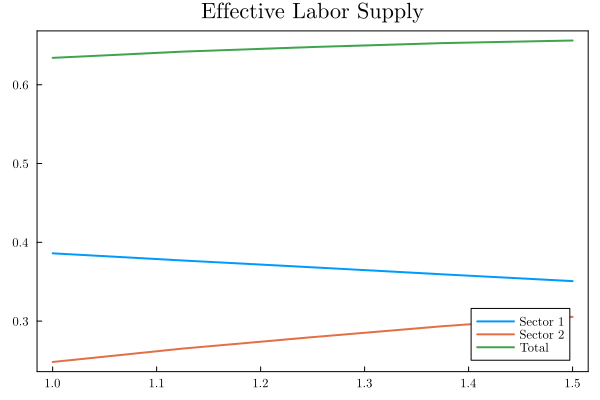

In [36]:
plot(W2, sector_shock[5,:], label="Sector 1", title="Effective Labor Supply")
plot!(W2, sector_shock[6,:], label="Sector 2")
plot!(W2, sector_shock[7,:], label="Total")

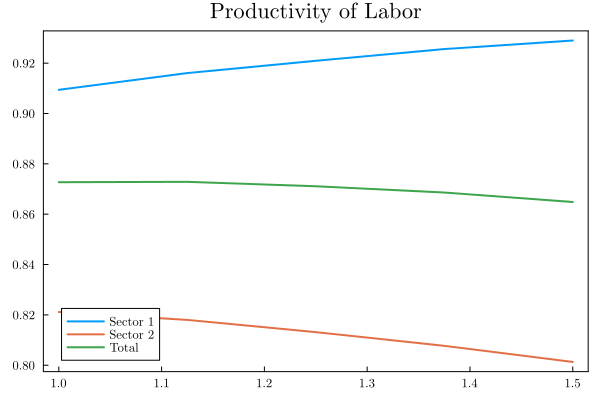

In [37]:
plot(W2, sector_shock[8,:], label="Sector 1", title="Productivity of Labor")
plot!(W2, sector_shock[9,:], label="Sector 2")
plot!(W2, sector_shock[10,:], label="Total")

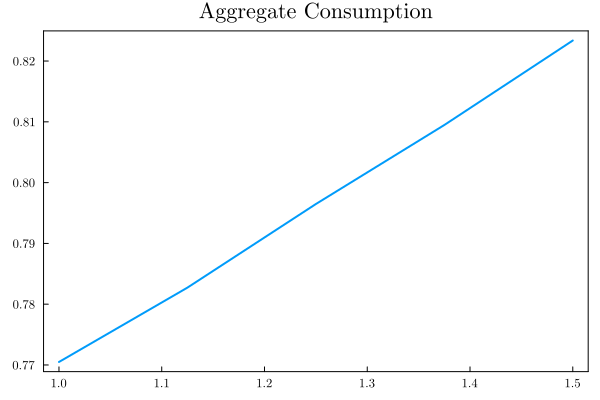

In [38]:
plot(W2, sector_shock[11,:], title="Aggregate Consumption")

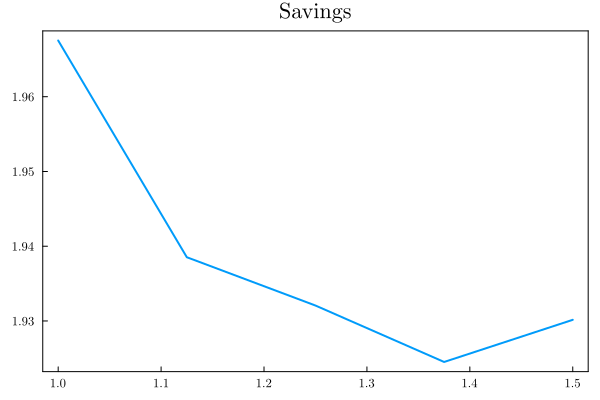

In [39]:
plot(W2, sector_shock[12,:], title="Savings")

In [40]:
ginivec = [gini(WDIST[i,:]) for i in 1:5]

5-element Vector{Float64}:
 0.3409168589560915
 0.36448727069502496
 0.3805730096534424
 0.3990368109734266
 0.4114387184311863

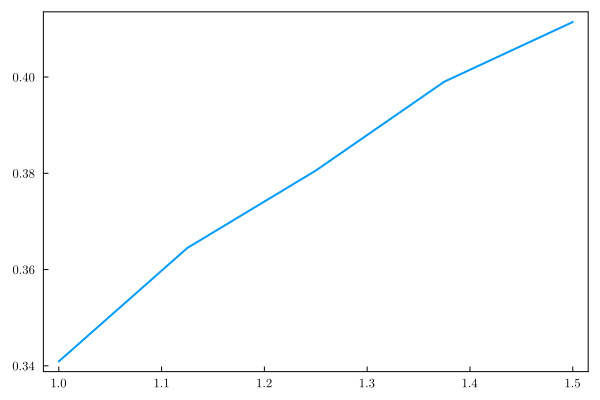

In [41]:
plot(W2, ginivec)

# GE Analysis

In [16]:
w1, w2 = eq_prices(0.36, 0.36, 0.03, 0.5, 0.7, 0.3, 50, 1, 1, 0.7)

Current prices, r=0.03, w1=0.36, w2=0.36
Starting Value Function Iteration
Starting Value Function Iteration
0.7110808467904973
0.8524197247468819
Current prices, r=0.03, w1=0.5593934594446701, w2=0.5593934594446701
Starting Value Function Iteration
Starting Value Function Iteration
0.15443113470618702
0.23623298675894716
Current prices, r=0.03, w1=0.6532584490498003, w2=0.6532584490498003
Starting Value Function Iteration
Starting Value Function Iteration
0.02299725588245405
0.06311448110424128
Current prices, r=0.03, w1=0.670927726453134, w2=0.670927726453134
Starting Value Function Iteration
Starting Value Function Iteration
0.0025824269285139034
0.017664740413021962
Current prices, r=0.03, w1=0.6729890525132919, w2=0.6729890525132919
Starting Value Function Iteration
Starting Value Function Iteration
0.0003023063329542497
0.005134963980212959
Approximate equilibrium found at r=0.03, w1 = 0.6729890525132919, w2 = 0.6729890525132919
